# **Experiment: Evaluate Hallucination Detection Frameworks Performance**

**DESCRIPTION:**
1. Extract atomic facts from real Q-A pairs using GPT-4o and a structured fact-splitting prompt.
2. Intentionally corrupt a subset of those facts via a dedicated hallucination-generation prompt to create labelled true vs. hallucinated statements.
3. Score each fact with three independent detectors (Vectara, UpTrain, Ragas) and log metrics, producing a reusable benchmark for hallucination-detection models.
4. Make sure to run this notebook on Colab


**REQUIREMENTS**

In [1]:
!pip install uptrain==0.7.1 rouge-score==0.1.2 transformers==4.52.4 torch==2.6.0+cu124 openai==1.86.0 ragas==0.2.15

**PROMPTS**

In [2]:
FACT_GENERATE_PROMPT_TEMPLATE = """
You are given a response along with its related question. Your task is to extract independent factual statements from the response. A **fact** is a sentence that:
- Is **objectively true based on the response**
- Does **not rely on other facts to be understood**
- Is **not redundant** or a paraphrase of another fact
- Should **not infer or assume** anything beyond what's stated

{scenario_description}

Example Data:
{few_shot_examples}

Return the output **only** in the following JSON format:
{output_format}

Task Data:
[Question]: {question}
[Response]: {response}
[Output]:
"""

SCENARIO_DESCRIPTION = """
This task aims to break complex, compound, or descriptive responses into smaller factual units. These facts should stand alone and preserve the meaning without depending on contextual glue. Avoid merging facts or making assumptions. Do not repeat or paraphrase.
"""

FEW_SHOT_EXAMPLES = """
[Question]: Which is the tallest monument in Paris?
[Response]: The Eiffel Tower, located in Paris, is one of the most visited monuments in the world. It was named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889, it was initially criticized by some of France's leading artists and intellectuals.
[Output]:
[
    { "Fact": "The Eiffel Tower is located in Paris." },
    { "Fact": "The Eiffel Tower is one of the most visited monuments in the world." },
    { "Fact": "The Eiffel Tower was named after engineer Gustave Eiffel." },
    { "Fact": "Gustave Eiffel's company designed and built the Eiffel Tower." },
    { "Fact": "The Eiffel Tower was constructed between 1887 and 1889." },
    { "Fact": "The Eiffel Tower was initially criticized by some French artists and intellectuals." }
]

[Question]: Who discovered penicillin?
[Response]: Penicillin was discovered by Alexander Fleming in 1928. He found it while working at St. Mary's Hospital in London. It later became the first widely used antibiotic.
[Output]:
[
    { "Fact": "Penicillin was discovered by Alexander Fleming in 1928." },
    { "Fact": "Alexander Fleming discovered penicillin while working at St. Mary's Hospital in London." },
    { "Fact": "Penicillin was the first widely used antibiotic." }
]

[Question]: What causes tides on Earth?
[Response]: Tides are caused primarily by the gravitational pull of the Moon and, to a lesser extent, the Sun. These celestial bodies exert forces that cause Earth's oceans to bulge, creating high and low tides.
[Output]:
[
    { "Fact": "Tides are caused primarily by the gravitational pull of the Moon." },
    { "Fact": "The Sun also contributes to the formation of tides." },
    { "Fact": "Gravitational forces from the Moon and Sun cause Earth's oceans to bulge." },
    { "Fact": "These ocean bulges result in high and low tides." }
]
"""

OUTPUT_FORMAT = """
{
    "Facts": [
        "1st Fact",
        "2nd Fact",
        ...
    ]
}
In case of no facts, return an empty list: []
"""

HALLUCINATION_PROMPT_TEMPLATE = """
You are a **Hallucination Generator**. Each fact below is currently correct.
Rewrite every fact so it becomes subtly **incorrect** while still sounding
plausible in the given context.

You may introduce hallucinations using these tactics:

1. **False Negative** – Context has the answer, but you reply “I don’t know.”
2. **Context Override** – Ignore the (incorrect) context and answer from world knowledge.
3. **Fabrication** – Invent details absent from all retrieved chunks.
4. **Misinterpretation** – Misread the context and answer accordingly.
5. **Over-generalization** – Give a broad, vague answer not backed by context.
6. **Contradiction** – State the opposite of what the context says.
7. **Conflict Merge** – Combine contradictory chunks into one flawed statement.
8. **Span Error** – Pull the wrong span from context due to ambiguity.

---

### Context
{context_text}

### Facts to Hallucinate
{fact_str}

### Output (JSON only)
{{
  "hallucinated_fact_1": "<hallucinated text>",
  "hallucinated_fact_2": "<hallucinated text>"
}}
"""


**IMPORTS**

In [ ]:
import os
import json
import random
import asyncio
from pathlib import Path
from typing import List, Dict, Any

from openai import OpenAI
from transformers import pipeline, AutoTokenizer
from uptrain import EvalLLM, Evals
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import Faithfulness
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI


OPENAI_API_KEY = "your-key"
assert OPENAI_API_KEY, "Set OPENAI_API_KEY variable!"

client = OpenAI(api_key=OPENAI_API_KEY)

**GENERAL FUNCTIONS**

In [4]:


def _balanced_json_slice(text: str) -> str:
    """Return the first balanced JSON object found in `text`."""
    start = text.find("{")
    if start == -1:
        raise ValueError("No opening { found")
    depth = 0
    for idx, ch in enumerate(text[start:], start=start):
        if ch == "{":
            depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return text[start : idx + 1]
    raise ValueError("Unbalanced JSON braces")


def extract_json(text: str) -> Dict[str, Any]:
    """Safely extract JSON from an LLM response."""
    try:
        return json.loads(_balanced_json_slice(text))
    except Exception as e:
        print(f"⚠️ JSON extraction failed: {e}")
        return {}


def load_json(path: str | Path) -> Any:
    with open(path, "r") as fp:
        return json.load(fp)


def save_json(obj: Any, path: str | Path):
    with open(path, "w") as fp:
        json.dump(obj, fp, indent=2)

def generate_facts(question: str, response: str) -> List[str]:
    """Extract atomic facts from a question/response pair."""
    prompt = FACT_GENERATE_PROMPT_TEMPLATE.format(
        scenario_description=SCENARIO_DESCRIPTION,
        few_shot_examples=FEW_SHOT_EXAMPLES,
        output_format=OUTPUT_FORMAT,
        question=question,
        response=response,
    )

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.2,
    )

    result = extract_json(completion.choices[0].message.content)
    return result.get("Facts", [])

def hallucinate_facts(
    facts: List[str],
    context_chunks: List[str],
    temperature: float = 0.7,
) -> Dict[str, str]:
    """
    Ask the LLM to deliberately introduce hallucinations by returning a mapping
    {original_fact: hallucinated_fact}.
    """
    context_text = "\n".join(context_chunks)
    fact_str = "\n".join(f"- {f}" for f in facts)

    prompt = HALLUCINATION_PROMPT_TEMPLATE.format(
        context_text=context_text, fact_str=fact_str
    )

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a hallucination generator."},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature,
    )

    reply_json = extract_json(completion.choices[0].message.content)

    mapping = {}
    for idx, original in enumerate(facts, start=1):
        key = f"hallucinated_fact_{idx}"
        mapping[original] = reply_json.get(key, original)
    return mapping

def build_vectara_classifier():
    """Return HF pipeline for hallucination detection (Vectara)."""
    return pipeline(
        "text-classification",
        model="vectara/hallucination_evaluation_model",
        tokenizer=AutoTokenizer.from_pretrained("google/flan-t5-base"),
        trust_remote_code=True,
    )

def build_uptrain_evaluator():
    return EvalLLM(openai_api_key=OPENAI_API_KEY)



async def ragas_single_fact_score(
    question: str, response: str, contexts: List[str]
) -> float | None:
    """Async faithfulness score for one fact using Ragas."""
    try:
        evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
        faithfulness_scorer = Faithfulness(llm=evaluator_llm)
        sample = SingleTurnSample(
            user_input=question, response=response, retrieved_contexts=contexts
        )
        score = await faithfulness_scorer.single_turn_ascore(sample)
        return round(score, 4)
    except Exception:
        return None

def binary_metrics(y_true: List[bool], y_pred: List[bool]) -> Dict[str, float]:
    """Return accuracy/precision/recall/f1 for binary labels."""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }

def process_dataset(
    qa_path: str | Path,
    out_dir: str | Path = "outputs",
    sample_size: int | None = None,
):
    """
    End‑to‑end pipeline:
    1. Extract facts
    2. Hallucinate subset
    3. Score with Vectara / UpTrain / Ragas
    4. Persist results + metrics
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    qa_items = load_json(qa_path)
    if sample_size:
        qa_items = random.sample(qa_items, sample_size)

    vectara = build_vectara_classifier()
    uptrain_eval = build_uptrain_evaluator()

    processed: List[Dict[str, Any]] = []

    for entry in qa_items:
        q, a, docs = entry["question"], entry["answer"], entry.get("documents", [])
        facts = generate_facts(q, a)
        if not facts:
            continue

        # Hallucinate ~half of the facts
        k = max(1, len(facts) // 2)
        selected = random.sample(facts, k)
        mapping = hallucinate_facts(selected, docs)

        # Build labelled facts list
        labelled: List[Dict[str, Any]] = []
        for f in facts:
            hallucinated = f in mapping
            text = mapping.get(f, f)

            # Vectara
            prompt = (
                "<pad> Determine if the hypothesis is true given the premise?\n\n"
                f"Premise: {' '.join(docs)}\n\nHypothesis: {text}"
            )
            vectara_score = vectara(prompt, top_k=None)
            consistent = next(s for s in vectara_score if s["label"] == "consistent")[
                "score"
            ]

            # UpTrain
            up_res = uptrain_eval.evaluate(
                data=[{"question": q, "context": docs, "response": text}],
                checks=[Evals.FACTUAL_ACCURACY],
            )[0]
            uptrain_score = up_res["score_factual_accuracy"]

            labelled.append(
                {
                    "fact": text,
                    "hallucinated": hallucinated,
                    "vectara_score": consistent,
                    "uptrain_score": uptrain_score,
                }
            )

        processed.append(
            {
                "question": q,
                "original_answer": a,
                "context": docs,
                "labelled_facts": labelled,
            }
        )

    # Save intermediate JSON
    save_json(processed, out_dir / "processed.json")

    # Compute binary metrics using UpTrain threshold
    y_true, y_pred = [], []
    for item in processed:
        for lf in item["labelled_facts"]:
            y_true.append(lf["hallucinated"])
            y_pred.append(lf["uptrain_score"] < 1.0)

    save_json(binary_metrics(y_true, y_pred), out_dir / "uptrain_vectara_ragas_performace_metrics.json")
    print(f"✅ Pipeline complete. Results in {out_dir}")




**DATASET PREPARATION**

From the dataset mentioned in references, choose sub dataset of your choice and format it like this in a json file and name it input.json or refer to dataset_creation.ipynb notebook
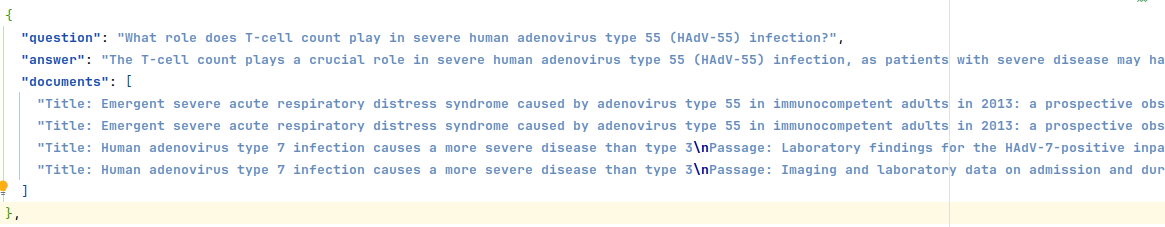

In [ ]:
if __name__ == "__main__":
    process_dataset("input.json", out_dir="run_outputs", sample_size=50)

**REFERENCES**  
https://huggingface.co/datasets/galileo-ai/ragbench/viewer/techqa?views%5B%5D=techqa_train&row=49

https://github.com/uptrain-ai/uptrain/blob/main/uptrain/operators/language/prompts/classic.py

https://huggingface.co/vectara/hallucination_evaluation_model

https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/faithfulness/

https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy
